In [344]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


In [345]:
df=pd.read_csv('Data/train.csv')

## Data Description

Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes

pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [346]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [347]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Removing Missing Values

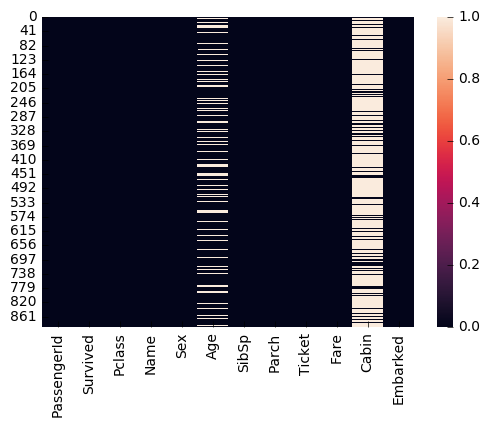

In [348]:
sns.heatmap(df.isnull())

The Cabin column seems worthless (for now), but I'm going to try to complete the Age column with some estimates.

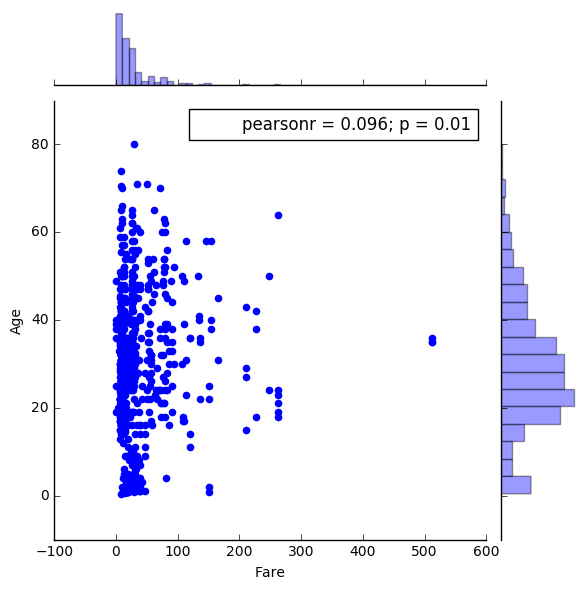

In [349]:
sns.jointplot(x="Fare", y="Age", data=df)

No real correlation between Fare and Age.

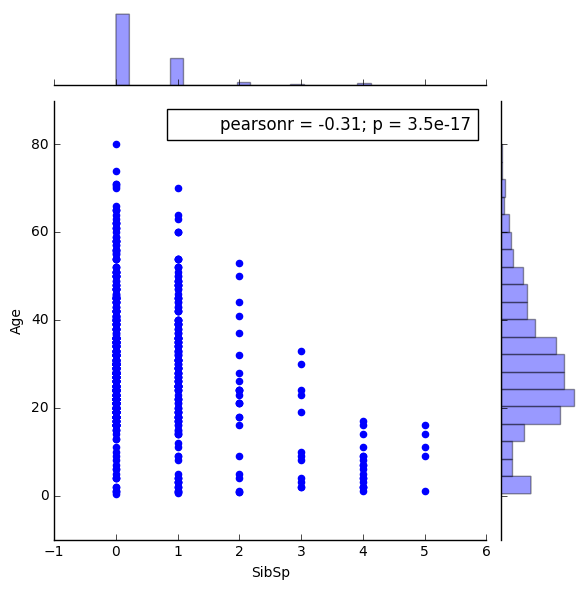

In [350]:
sns.jointplot(x="SibSp", y="Age", data=df)

Some inverse correlation, it would make sense that older people would have less siblings, and younger people more.

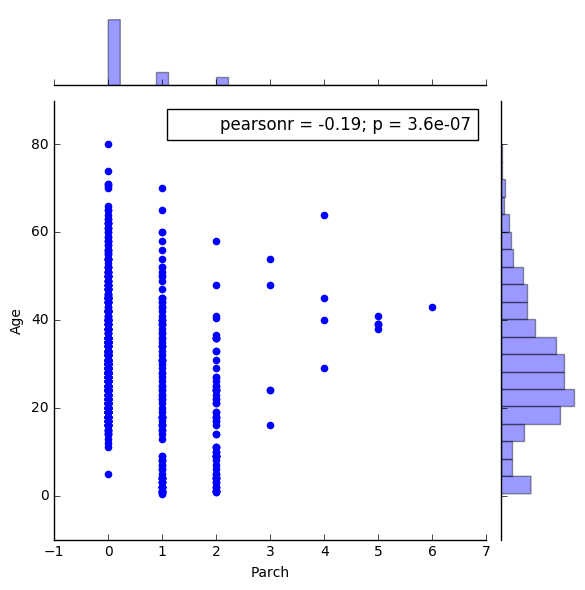

In [351]:
sns.jointplot(x="Parch", y="Age", data=df)

Doesn't seem to be much there, so I'll assign age based on the average age of passengers with the same number of siblings aboard.

In [352]:
df.groupby('SibSp').mean()

,PassengerId,Survived,Pclass,Age,Parch,Fare
SibSp,,,,,,
0,455.370066,0.345395,2.351974,31.397558,0.185855,25.692028
1,439.727273,0.535885,2.057416,30.089727,0.655502,44.147370
2,412.428571,0.464286,2.357143,22.620000,0.642857,51.753718
3,321.562500,0.250000,2.562500,13.916667,1.312500,68.908862
4,381.611111,0.166667,3.000000,7.055556,1.500000,31.855556
5,336.800000,0.000000,3.000000,10.200000,2.000000,46.900000
8,481.714286,0.000000,3.000000,NaN,2.000000,69.550000


In [353]:
sibsToAge={0:31, 1:30, 2:23, 3:14, 4:7, 5:10, 8:10}
def ageFiller(col):
    age=col[0]
    sibs=col[1]
    if pd.isnull(age):
        return sibsToAge[sibs]
    else:
        return age
df['Age']=df[['Age', 'SibSp']].apply(ageFiller, axis=1)

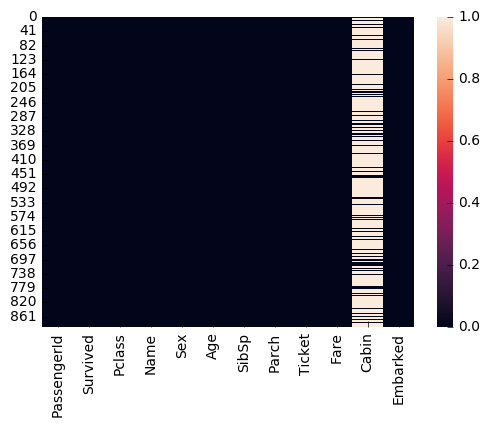

In [354]:
sns.heatmap(df.isnull())

Age is all done!

In [355]:
df=df.drop('Cabin', axis=1)

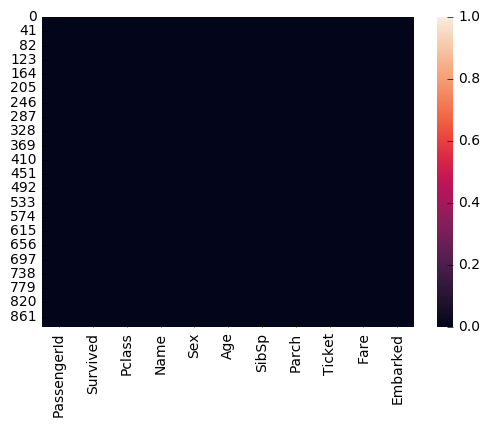

In [356]:
sns.heatmap(df.isnull())

Missing values are all taken care of!

## Prepare Data for Models

Categorical variables need to be transformed into dummy variables so that they can be fed to models.

In [357]:
sex = pd.get_dummies(df['Sex'],drop_first=True)
embark = pd.get_dummies(df['Embarked'],drop_first=True)
df.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
df = pd.concat([df,sex,embark],axis=1)
df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1.0,0.0,1.0
1,2,1,1,38.0,1,0,71.2833,0.0,0.0,0.0
2,3,1,3,26.0,0,0,7.9250,0.0,0.0,1.0
3,4,1,1,35.0,1,0,53.1000,0.0,0.0,1.0
4,5,0,3,35.0,0,0,8.0500,1.0,0.0,1.0


## Get Modeling!

In [358]:
from sklearn.model_selection import train_test_split

In [359]:
xTrain, xTest, yTrain, yTest = train_test_split(df.drop('Survived', axis=1), df['Survived'], test_size=0.3)

### Logistic Regression

In [360]:
from sklearn.linear_model import LogisticRegression

In [361]:
logistic = LogisticRegression()
logistic.fit(xTrain,yTrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [362]:
logisticPredictions = logistic.predict(xTest)

In [363]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(yTest, logisticPredictions))
print(classification_report(yTest,logisticPredictions))

[[146  19]
 [ 31  72]]
             precision    recall  f1-score   support

          0       0.82      0.88      0.85       165
          1       0.79      0.70      0.74       103

avg / total       0.81      0.81      0.81       268



### MLP Neural Network


In [364]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [365]:
scaler.fit(xTrain)
scaledXTrain=scaler.transform(xTrain)
scaledXTest=scaler.transform(xTest)

In [366]:
NN=MLPClassifier(hidden_layer_sizes=(30), alpha=.000001, max_iter=10000)
NN.fit(scaledXTrain, yTrain)

MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=30, learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [367]:
NNPredictions=NN.predict(scaledXTest)

In [368]:
print(confusion_matrix(yTest, NNPredictions))
print(classification_report(yTest,NNPredictions))

[[155  10]
 [ 37  66]]
             precision    recall  f1-score   support

          0       0.81      0.94      0.87       165
          1       0.87      0.64      0.74       103

avg / total       0.83      0.82      0.82       268



# Submission Data


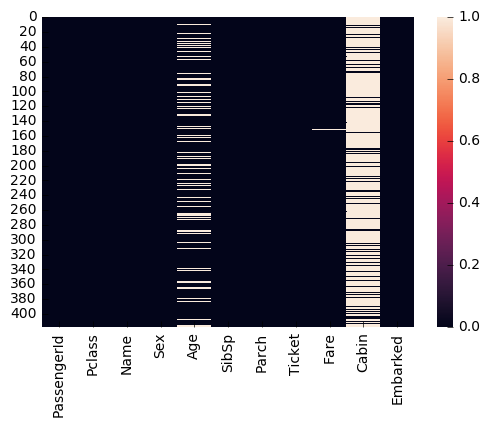

In [403]:
testDF=pd.read_csv('Data/test.csv')
sns.heatmap(testDF.isnull())

Fill in blank ages like above

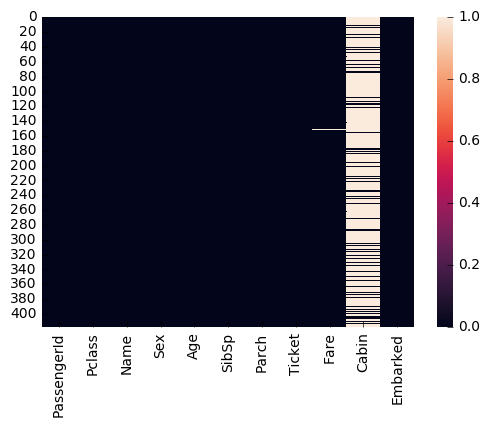

In [404]:
testDF['Age']=testDF[['Age', 'SibSp']].apply(ageFiller, axis=1)
sns.heatmap(testDF.isnull())

Remove the Cabin column, and fill that single pesky NaN Fare value with the mean

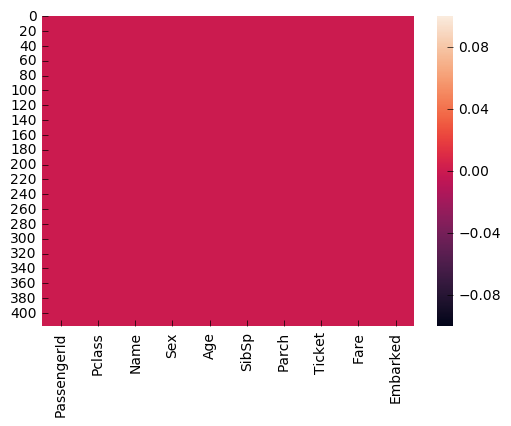

In [405]:
testDF=testDF.drop('Cabin', axis=1)
testDF=testDF.fillna(testDF.mean())
sns.heatmap(testDF.isnull())

In [406]:
sex = pd.get_dummies(testDF['Sex'],drop_first=True)
embark = pd.get_dummies(testDF['Embarked'],drop_first=True)
testDF.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
testDF = pd.concat([testDF,sex,embark],axis=1)

In [407]:
testDF.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,892,3,34.5,0,0,7.8292,1.0,1.0,0.0
1,893,3,47.0,1,0,7.0000,0.0,0.0,1.0
2,894,2,62.0,0,0,9.6875,1.0,1.0,0.0
3,895,3,27.0,0,0,8.6625,1.0,0.0,1.0
4,896,3,22.0,1,1,12.2875,0.0,0.0,1.0


In [408]:
testInput=scaler.transform(testDF)


In [409]:
results=NN.predict(testInput)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
PassengerId    418 non-null int64
Survived       418 non-null int64
dtypes: int64(2)
memory usage: 6.6 KB


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


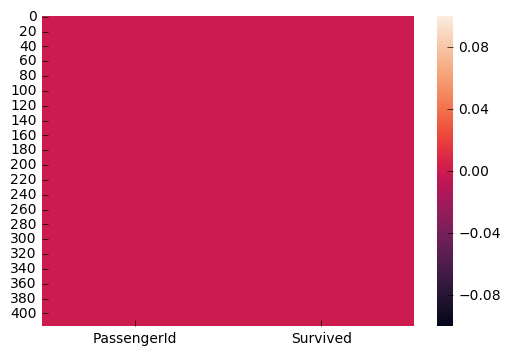

In [410]:
resultDF=pd.concat([testDF['PassengerId'], pd.Series(results)], axis=1, keys=['PassengerId', 'Survived'])
resultDF.info()
sns.heatmap(resultDF.isnull())
resultDF['PassengerId']=resultDF['PassengerId'].apply(lambda x: int(x))
resultDF['Survived']=resultDF['Survived'].apply(lambda x: int(x))
resultDF.head(10)

In [412]:
resultDF.to_csv('submission.csv', index=False)